In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from funkwpap import sympy_to_gurobi, Firm, Country, Sector, Regulator, get_emission
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt

In [2]:
x, y = sp.symbols('x y')
# Create Sectors and Countries
Regulator11 = Regulator("test1", permit_price = 2.4079, emission_cap = 50)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator11)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator11)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator11)
country1 = Country('DE', 1, regulator= Regulator11)
country2 = Country('FI', 0.5, regulator= Regulator11)
country3 = Country('GR', size= 0.1, regulator= Regulator11)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 10*x+ 2*x**2 + 0.1*x**3 , 0, 0, 0, regulator= Regulator11)
firm2 = Firm('firm2', 1, 2, x*0, 11*x+ 3*x**2 + 0.2*x**3, 0, 0, 0, regulator= Regulator11)
firm3 = Firm('firm3', 1, 3, x*0, 5*x+ 4*x**2 + 5*x**3 , 0, 0, 0, regulator= Regulator11)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator11)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator11)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator11)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator11)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator11)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator11)


print(sector1.firms)  # List of firms in sector1
print(country1.firms)  # List of firms in country1
print(Regulator11.firm_registry)  # Dictionary of all firms

for firm in Regulator11.firm_registry.values():
    print(firm.name, firm.sector.name, firm.country.name)

[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0)]
[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=7, name='firm7', sector_id=3, country_id=1, actual_output=0, emission=0, profit=0)]
{1: Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), 2: Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), 3: Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0), 4: Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), 5: Firm(id=5, name='firm5', sector_id=2, country_id=2, actual_out

In [3]:
# Read a csv file that has the column names in the first row and some entries are lists of floats which are writeen inside double quotes to seperate those commas from the commans of the scv file. 
with open ('../data/generated/exp01_varying_free_alloc_of_sector_1_at_90_per_cent_BAU.csv', 'r') as f:
    df = pd.read_csv(f)

# print(df)

In [4]:
Sales = []
Abatements = []
Trades = []
Outputs = []
Emissions = []
Profits = []

for i in range(len(df)):
    Regulator11.emission_cap = df.loc[i, 'Emission Cap']
    Regulator11.permit_price = df.loc[i, 'Permit Price']
    out = df.loc[i, 'Outputs'].replace('(', '').replace(')', '').replace('[', '').replace(']', '').split(',')
    em = df.loc[i, 'Emissions'].replace('(', '').replace(')', '').replace('[', '').replace(']', '').split(',')
    pr = df.loc[i, 'Profits'].replace('(', '').replace(')', '').replace('[', '').replace(']', '').split(',')
    sal = []
    abat = []
    trad = []

    for firm in Regulator11.firm_registry.values():
        firm.actual_output = float(out[firm.id - 1])
        firm.emission = float(em[firm.id - 1])
        firm.profit = float(pr[firm.id - 1])
        sal.append(firm.calculate_sales())
        abat.append(firm.calculate_abatement())
        trad.append(firm.calculate_trading())
    Sales.append(sal)
    Abatements.append(abat)
    Trades.append(trad)
    Outputs.append(out)
    Emissions.append(em)
    Profits.append(pr)

print(Trades)

# Combine all the data back into one dataframe
df['Sales'] = Sales
df['Abatements'] = Abatements
df['Trades'] = Trades
df['Outputs'] = Outputs
df['Emissions'] = Emissions
df['Profits'] = Profits
print(df)

# Go through the columns "Sales", "Abatements", "Trades", "Outputs", "Emissions", "Profits" and convert the list of strings to list of floats
for col in ["Sales", "Abatements", "Trades", "Outputs", "Emissions", "Profits"]:
    for i in range(len(df)):
        df.at[i, col] = [float(x) for x in df.loc[i, col]]

df.to_csv('../data/generated/exp01_varying_free_alloc_of_sector_1_at_90_per_cent_BAU.csv', index=False)

[[2903.55282019222, 2909.23422156747, 2907.42809777879, 4592.62107796575, 4588.62598624252, 4590.79976238150, 1511.94143283208, 1513.88913838287, 1514.54958770025], [2919.03233072493, 2924.79496815798, 2923.07264947791, 4611.22819953687, 4607.22185009608, 4609.41047633123, 1518.39311364418, 1520.35500621531, 1521.02573111925], [2934.67114447475, 2940.51659433901, 2938.87930179821, 4629.98024835676, 4625.96260341065, 4628.16625658602, 1524.89916422407, 1526.87666228315, 1527.54916675788], [2950.47897754044, 2956.40934354006, 2954.85757150450, 4648.89066973620, 4644.86168476970, 4647.08055418552, 1531.46320917292, 1533.45739514282, 1534.13478033356], [2966.45647609288, 2972.47185098151, 2971.00878577129, 4667.95648204625, 4663.91611576470, 4666.15059296364, 1538.08341076837, 1540.09699059170, 1540.77677407977], [2982.60591968232, 2988.70763550087, 2987.33625412273, 4687.18097147960, 4683.12918207981, 4685.38086050542, 1544.76403400787, 1546.79151269161, 1547.47989234186], [2998.927959576

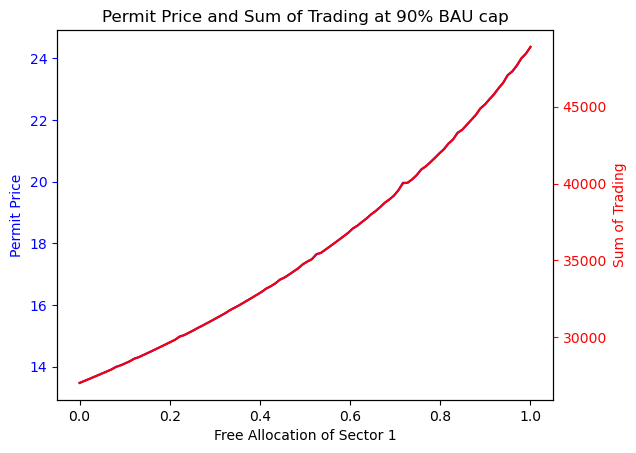

In [5]:


# Plot the permit price against the emission cap
fig, ax1 = plt.subplots()

ax1.plot(df['Free Allocation'][0:], df['Permit Price'][0:], 'b-')
ax1.set_xlabel('Free Allocation of Sector 1')
ax1.set_ylabel('Permit Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
trading_sums = [sum(trading) for trading in df['Trades']]
ax2.plot(df['Free Allocation'][0:], trading_sums, 'r-')
ax2.set_ylabel('Sum of Trading', color='r')
ax2.tick_params('y', colors='r')

plt.title('Permit Price and Sum of Trading at 90% BAU cap')
plt.show()

   

In [6]:
indexes_of_sector_1 = [firm.id for firm in Regulator11.firm_registry.values()if firm.sector.id == 1]
indexes_of_sector_2 = [firm.id for firm in Regulator11.firm_registry.values() if firm.sector.id == 2]
indexes_of_sector_3 = [firm.id for firm in Regulator11.firm_registry.values() if firm.sector.id == 3]
print(indexes_of_sector_1)



[1, 2, 3]


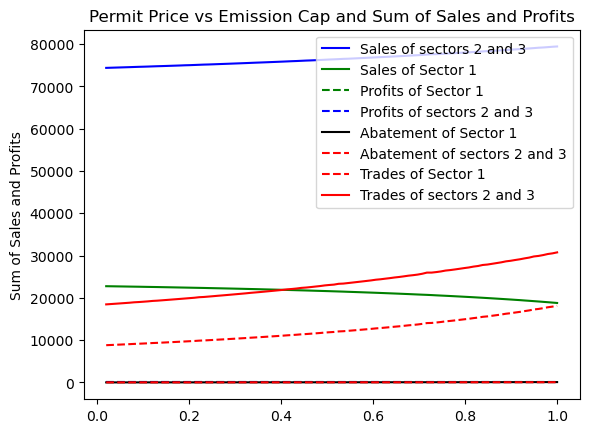

In [7]:
import matplotlib.pyplot as plt

first_element_to_plot = 2
last_element_to_plot = 100

# Plot the permit price against the emission cap
fig, ax1 = plt.subplots()

indexes_of_sector_1 = [firm.id for firm in Regulator11.firm_registry.values() if firm.sector.id == 1]
indexes_of_sector_2 = [firm.id for firm in Regulator11.firm_registry.values() if firm.sector.id == 2]
indexes_of_sector_3 = [firm.id for firm in Regulator11.firm_registry.values() if firm.sector.id == 3]


sales_sums = [sum(sales[i-1] for i in range(len(sales)) if i not in indexes_of_sector_1) for sales in df['Sales']]
sales_sum_of_sector_1 = [sum(sales[i-1] for i in indexes_of_sector_1) for sales in df['Sales']]
profits_of_sector_1 = [sum(profits[i-1] for i in indexes_of_sector_1) for profits in df['Profits']]  # Assuming df['Profits'] contains the profit data
profits_of_rest = [sum(profits[i-1] for i in range(len(profits)) if i not in indexes_of_sector_1) for profits in df['Profits']]
abatement_of_sector_1 = [sum(abatements[i-1] for i in indexes_of_sector_1) for abatements in df['Abatements']]
abatement_of_rest = [sum(abatements[i-1] for i in range(len(abatements)) if i not in indexes_of_sector_1) for abatements in df['Abatements']]
trades_of_sector_1 = [sum(trades[i-1] for i in indexes_of_sector_1) for trades in df['Trades']]
trades_of_rest = [sum(trades[i-1] for i in range(len(trades)) if i not in indexes_of_sector_1) for trades in df['Trades']]


ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], sales_sums[first_element_to_plot:last_element_to_plot], 'b-', label='Sales of sectors 2 and 3')
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], sales_sum_of_sector_1[first_element_to_plot:last_element_to_plot], 'g-', label='Sales of Sector 1')
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], profits_of_sector_1[first_element_to_plot:last_element_to_plot], 'g--', label='Profits of Sector 1')  # Green dashed line for profits
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], profits_of_rest[first_element_to_plot:last_element_to_plot], 'b--', label='Profits of sectors 2 and 3')  # Blue dashed line for profits
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], abatement_of_sector_1[first_element_to_plot:last_element_to_plot], 'black', label='Abatement of Sector 1')  # Green dash-dot line for abatement
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], abatement_of_rest[first_element_to_plot:last_element_to_plot], 'r--', label='Abatement of sectors 2 and 3')  # Blue dash-dot line for abatement
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], trades_of_sector_1[first_element_to_plot:last_element_to_plot], 'r--', label='Trades of Sector 1')  # Red line for trades
ax1.plot(df['Free Allocation'][first_element_to_plot:last_element_to_plot], trades_of_rest[first_element_to_plot:last_element_to_plot], 'r-', label='Trades of sectors 2 and 3')  # Black line for trades

ax1.set_ylabel('Sum of Sales and Profits', color='black')
ax1.tick_params('y', colors='black')

# Add legends
ax1.legend(loc='best')

plt.title('Permit Price vs Emission Cap and Sum of Sales and Profits')
plt.show()